# DuckDB Carrier Invoice Data Analysis

This notebook demonstrates how to query and analyze the carrier invoice data stored in DuckDB.

**Data Summary:**
- Database: Latest export with exact date filtering (2025-08-09)
- Records: 144,910 records
- Columns: 263 columns
- Tracking Numbers: 32,384 unique tracking numbers

In [53]:
# Import required libraries
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

# Database path
DB_PATH = "../../carrier_invoice_extraction.duckdb"

print(f"Database: {DB_PATH}")
print(f"Exists: {os.path.exists(DB_PATH)}")

Database: ../../carrier_invoice_extraction.duckdb
Exists: True


In [54]:
# Connect to DuckDB
conn = duckdb.connect(DB_PATH)

# Basic info
total_records = conn.execute("SELECT COUNT(*) FROM carrier_invoice_extraction.carrier_invoice_data").fetchone()[0]
print(f"Total Records: {total_records:,}")

# Show table structure
columns = conn.execute("DESCRIBE carrier_invoice_extraction.carrier_invoice_data").fetchall()
print(f"\nColumns ({len(columns)}):")
for i, col in enumerate(columns[:10]):  # Show first 10 columns
    print(f"  {i+1}. {col[0]} ({col[1]})")
if len(columns) > 10:
    print(f"  ... and {len(columns) - 10} more columns")

Total Records: 144,910

Columns (263):
  1. version (VARCHAR)
  2. recipient_number (VARCHAR)
  3. account_number (VARCHAR)
  4. account_country_territory (VARCHAR)
  5. invoice_date (VARCHAR)
  6. invoice_number (VARCHAR)
  7. invoice_type_code (VARCHAR)
  8. invoice_type_detail_code (VARCHAR)
  9. account_tax_id (VARCHAR)
  10. invoice_currency_code (VARCHAR)
  ... and 253 more columns


## 1. Basic Data Overview

In [55]:
# Get basic statistics
overview_df = conn.execute("""
    SELECT 
        COUNT(*) as total_records,
        COUNT(DISTINCT tracking_number) as unique_tracking,
        COUNT(DISTINCT invoice_number) as unique_invoices,
        COUNT(DISTINCT sender_company_name) as unique_senders,
        COUNT(DISTINCT receiver_company_name) as unique_receivers,
        ROUND(SUM(CAST(net_amount AS DECIMAL)), 2) as total_net_amount
    FROM carrier_invoice_extraction.carrier_invoice_data
    WHERE tracking_number IS NOT NULL AND tracking_number != ''
""").df()

display(overview_df)

,total_records,unique_tracking,unique_invoices,unique_senders,unique_receivers,total_net_amount
0,144281,32384,146,1408,24213,546237.85


## 2. Top Senders Analysis

,sender_company_name,shipments,unique_packages,total_amount
0,SHIPPING DEPARTMENT,19696,4227,56216.71
1,Shipping Department,13212,2630,50840.85
2,C/O BERGEN LOGISTICS NJ3,6345,1969,14626.17
3,Fulfillment Center,5707,1263,21775.78
4,Shipping Dept.,4640,1057,19815.27
5,Post & Porch,4217,878,15310.23
6,FASHIONPASS,3754,890,16850.64
7,GETPART LA INC,3612,860,12259.37
8,Bolt Logistics,3459,853,10565.05
9,Ship321,3163,595,10418.84


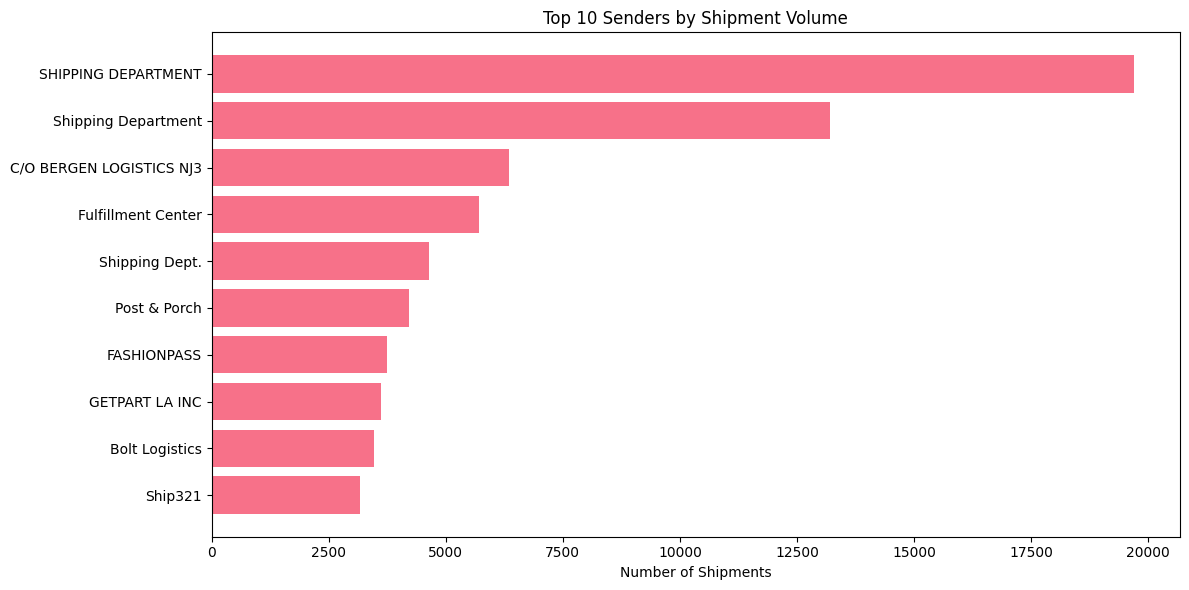

In [56]:
# Top senders by volume
top_senders_df = conn.execute("""
    SELECT 
        sender_company_name,
        COUNT(*) as shipments,
        COUNT(DISTINCT tracking_number) as unique_packages,
        ROUND(SUM(CAST(net_amount AS DECIMAL)), 2) as total_amount
    FROM carrier_invoice_extraction.carrier_invoice_data
    WHERE sender_company_name IS NOT NULL AND sender_company_name != ''
    GROUP BY sender_company_name
    ORDER BY shipments DESC
    LIMIT 15
""").df()

display(top_senders_df)

# Plot top senders
plt.figure(figsize=(12, 6))
plt.barh(top_senders_df['sender_company_name'][:10][::-1], 
         top_senders_df['shipments'][:10][::-1])
plt.title('Top 10 Senders by Shipment Volume')
plt.xlabel('Number of Shipments')
plt.tight_layout()
plt.show()

## 3. Geographic Analysis

,sender_state,receiver_state,shipments
0,CA,CA,9642
1,CA,TX,3483
2,CA,FL,2910
3,CA,NY,2520
4,WI,CA,1803
5,WI,TX,1631
6,NJ,NY,1570
7,NY,NY,1505
8,NJ,CA,1448
9,CA,TN,1447


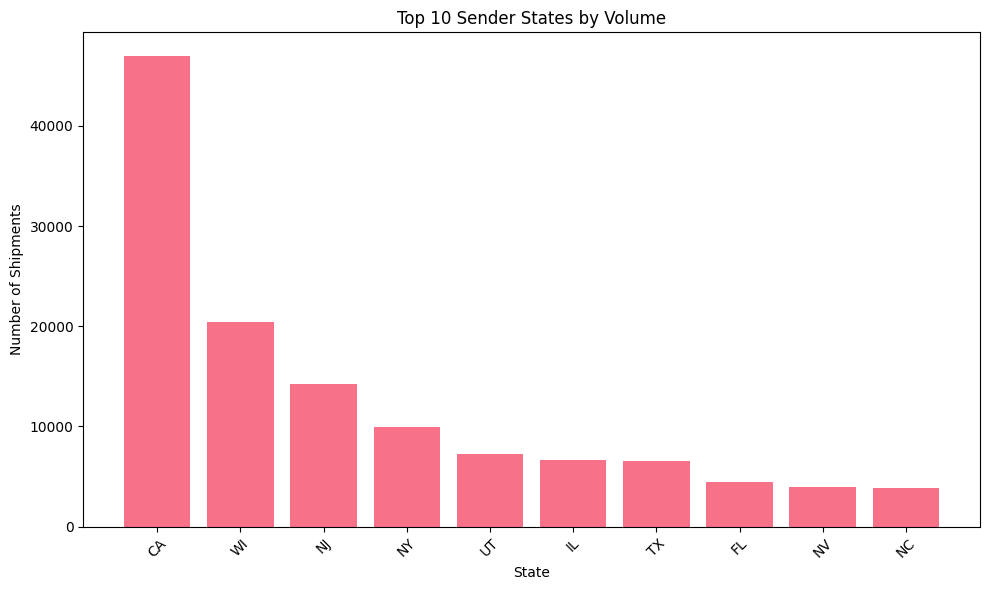

In [57]:
# Geographic distribution
geo_df = conn.execute("""
    SELECT 
        sender_state,
        receiver_state,
        COUNT(*) as shipments
    FROM carrier_invoice_extraction.carrier_invoice_data
    WHERE sender_state IS NOT NULL AND receiver_state IS NOT NULL
    AND sender_state != '' AND receiver_state != ''
    GROUP BY sender_state, receiver_state
    ORDER BY shipments DESC
    LIMIT 20
""").df()

display(geo_df)

# Top sender states
sender_states_df = conn.execute("""
    SELECT 
        sender_state,
        COUNT(*) as shipments
    FROM carrier_invoice_extraction.carrier_invoice_data
    WHERE sender_state IS NOT NULL AND sender_state != ''
    GROUP BY sender_state
    ORDER BY shipments DESC
    LIMIT 10
""").df()

plt.figure(figsize=(10, 6))
plt.bar(sender_states_df['sender_state'], sender_states_df['shipments'])
plt.title('Top 10 Sender States by Volume')
plt.xlabel('State')
plt.ylabel('Number of Shipments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Service Type Analysis

,charge_description,frequency,avg_amount,total_amount
0,Fuel Surcharge,31753,2.30,73093.11
1,Residential Surcharge,16558,2.04,33739.19
2,Ground Residential Third Party,15000,5.91,88588.05
3,Third Party Billing Service,14803,0.15,2211.52
4,Ground Residential,12284,5.67,69609.44
5,Ground Commercial Third Party,11795,5.95,70191.78
6,Ground Commercial,7439,6.28,46709.77
7,Delivery Area Surcharge,5560,2.11,11733.80
8,UPS Ground Saver - Less than 1 lb,3461,2.77,9572.43
9,UPS Ground Saver - 1 lb or Greater,2570,4.48,11518.96


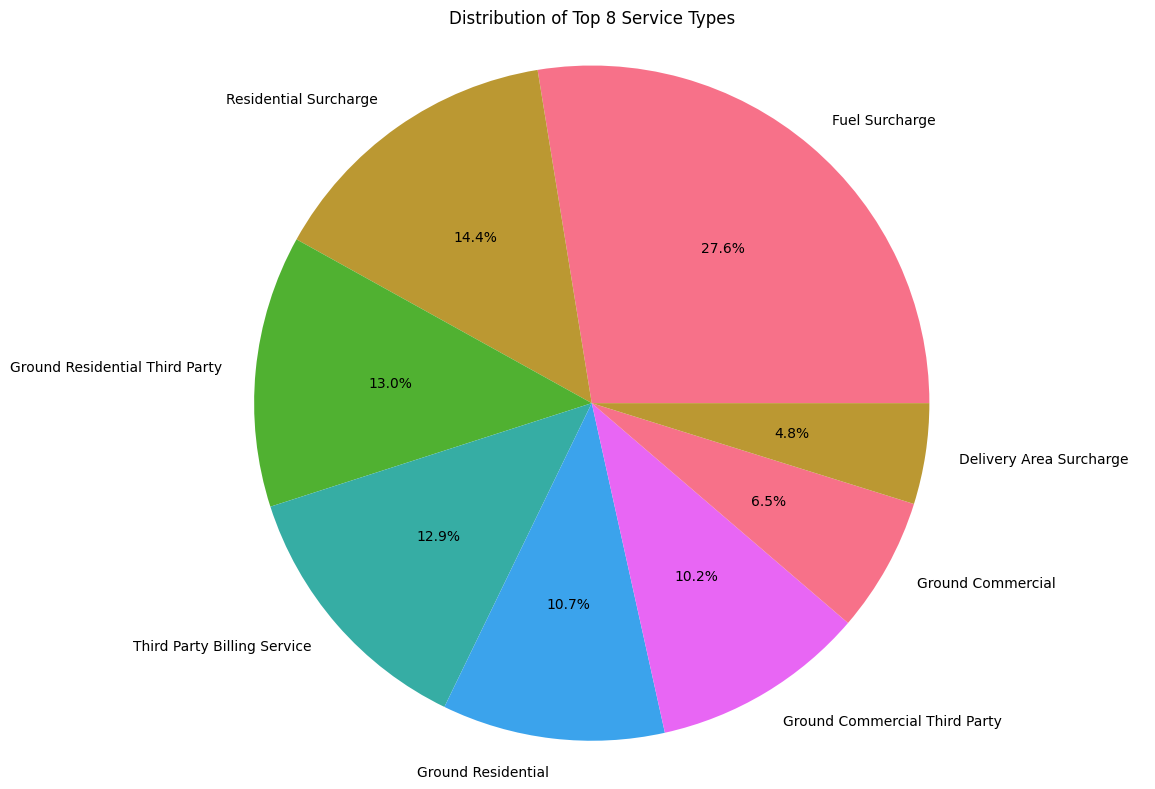

In [58]:
# Service types
services_df = conn.execute("""
    SELECT 
        charge_description,
        COUNT(*) as frequency,
        ROUND(AVG(CAST(net_amount AS DECIMAL)), 2) as avg_amount,
        ROUND(SUM(CAST(net_amount AS DECIMAL)), 2) as total_amount
    FROM carrier_invoice_extraction.carrier_invoice_data
    WHERE charge_description IS NOT NULL AND charge_description != ''
    GROUP BY charge_description
    ORDER BY frequency DESC
    LIMIT 15
""").df()

display(services_df)

# Plot service distribution
plt.figure(figsize=(12, 8))
plt.pie(services_df['frequency'][:8], 
        labels=services_df['charge_description'][:8], 
        autopct='%1.1f%%')
plt.title('Distribution of Top 8 Service Types')
plt.axis('equal')
plt.tight_layout()
plt.show()

## 5. Financial Analysis

,total_net_amount,avg_net_amount,min_net_amount,max_net_amount,total_records
0,559374.83,3.86,-152.5,1775.0,144910


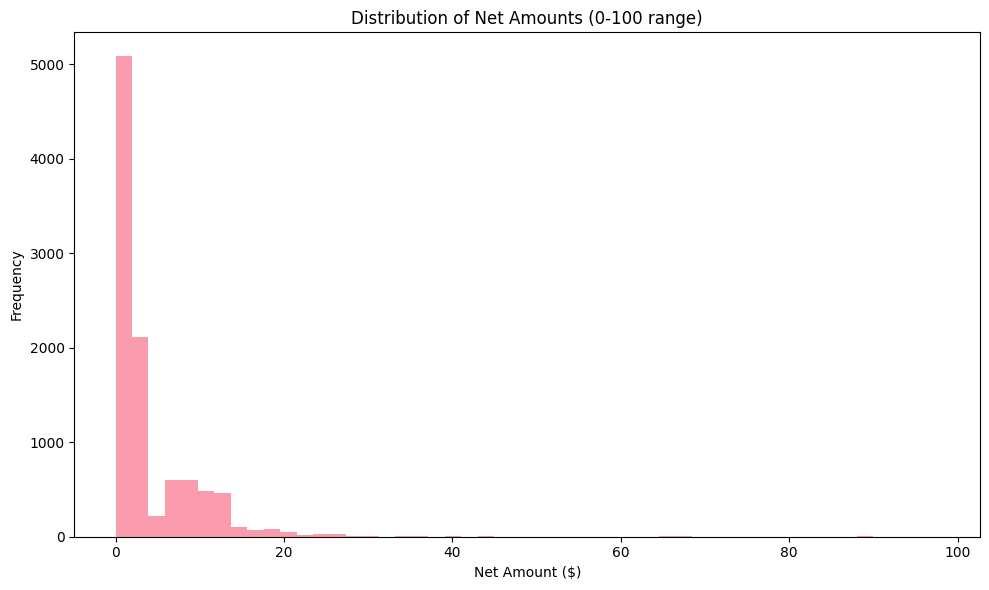

In [59]:
# Financial summary
financial_df = conn.execute("""
    SELECT 
        ROUND(SUM(CAST(net_amount AS DECIMAL)), 2) as total_net_amount,
        ROUND(AVG(CAST(net_amount AS DECIMAL)), 2) as avg_net_amount,
        ROUND(MIN(CAST(net_amount AS DECIMAL)), 2) as min_net_amount,
        ROUND(MAX(CAST(net_amount AS DECIMAL)), 2) as max_net_amount,
        COUNT(*) as total_records
    FROM carrier_invoice_extraction.carrier_invoice_data
    WHERE net_amount IS NOT NULL AND net_amount != ''
""").df()

display(financial_df)

# Amount distribution
amounts_df = conn.execute("""
    SELECT CAST(net_amount AS DECIMAL) as amount
    FROM carrier_invoice_extraction.carrier_invoice_data
    WHERE net_amount IS NOT NULL AND net_amount != ''
    AND CAST(net_amount AS DECIMAL) BETWEEN 0 AND 100
    LIMIT 10000
""").df()

plt.figure(figsize=(10, 6))
plt.hist(amounts_df['amount'], bins=50, alpha=0.7)
plt.title('Distribution of Net Amounts (0-100 range)')
plt.xlabel('Net Amount ($)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## 6. Custom Queries

Use this cell to run your own custom SQL queries:

In [60]:
# Custom query example - modify as needed
custom_query = """
SELECT 
    RIGHT(account_number,6) as account_number,
    tracking_number
FROM carrier_invoice_extraction.carrier_invoice_data




"""

result_df = conn.execute(custom_query).df()
display(result_df)
# Save to CSV
# result_df.to_csv("tracking_results.csv", index=False)

,account_number,tracking_number
0,04XA60,1Z2F6Y330335239010
1,04XA60,1Z2F6Y330307908224
2,04XA60,
3,04XA60,1Z2F6Y330337780896
4,04XA60,1Z2F6Y330337780896
...,...,...
144905,TT5537,1ZTT55371394846134
144906,TT5537,1ZTT55371394846134
144907,TT5537,1ZTT55370397867107
144908,TT5537,1ZTT55370398542152


In [61]:
# Close connection
conn.close()
print("✅ Database connection closed")

✅ Database connection closed
